In [9]:
'''
This notebook calculates splicing intermediates per intron and plots panels for Figure 4 and Figure S5
'''

'\nThis notebook calculates splicing intermediates per intron and plots panels for Figure 4 and Figure S5\n'

In [182]:
import os
import re
import glob

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import mygene
import scipy
import logomaker

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib as plt
matplotlib.rcParams['pdf.fonttype'] = 42 # export pdfs with editable font types in Illustrator

In [11]:
# Links to input data: BED12 files that have been filtered to remove polyA, 7SK and non-unique reads

dataFiles = [
    '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
     ]

# Link to intron annotation to get intron ID from coordinates
introns = pd.read_csv('../annotation_files/mm10_VM20_active_introns_unique_real_coordinates.bed',
                      delimiter = '\t', 
                      names =  ['chr', 'start', 'end', 'name', 'score', 'strand']) # active unique introns, filtered in previous script for Figure 2

# Link to splicing counts
spliced_counts = pd.read_csv('../Figure_2/intron_splicing_counts_for_PROseq_classification.txt', delimiter = '\t')

total_counts = pd.read_csv('../annotation_files/200628_5readcutoff_info.txt', sep = '\t', header = 0)

# Link to intron splice site scores etc.
intron_stats = pd.read_csv('../annotation_files/mm10_intron_length_gc_ss_score.txt', delimiter = '\t' 
                            )

In [13]:
# Generate two files for doing bedtools coverage: window around annotations of unique intron 5SS and 3SS

# set window length for generating window around splice sites
window = 25

# assign 3SS and 5SS based on strand
introns.loc[introns['strand'] == '+', 'threeSS'] = introns['end']
introns.loc[introns['strand'] == '-', 'threeSS'] = introns['start']
introns.loc[introns['strand'] == '+', 'fiveSS'] = introns['start']
introns.loc[introns['strand'] == '-', 'fiveSS'] = introns['end']

# convert coordinates to integer values
introns['threeSS'] = introns['threeSS'].astype(np.int64)
introns['fiveSS'] = introns['fiveSS'].astype(np.int64)

# make a window around 3SS using defined window length
introns.loc[introns['strand'] == '+', 'window3SS_start'] = (introns['threeSS'] - window)
introns.loc[introns['strand'] == '-', 'window3SS_start'] = (introns['threeSS'] - window)
introns.loc[introns['strand'] == '+', 'window3SS_end'] = (introns['threeSS'] + window)
introns.loc[introns['strand'] == '-', 'window3SS_end'] = (introns['threeSS'] + window)

# make a window around 5SS using defined window length
introns.loc[introns['strand'] == '+', 'window5SS_start'] = (introns['fiveSS'] - window)
introns.loc[introns['strand'] == '-', 'window5SS_start'] = (introns['fiveSS'] - window)
introns.loc[introns['strand'] == '+', 'window5SS_end'] = (introns['fiveSS'] + window)
introns.loc[introns['strand'] == '-', 'window5SS_end'] = (introns['fiveSS'] + window)

# return window start and end coordinates to intergers rather than floats
introns['window3SS_start'] = introns['window3SS_start'].astype(np.int64)
introns['window3SS_end'] = introns['window3SS_end'].astype(np.int64)
introns['window5SS_start'] = introns['window5SS_start'].astype(np.int64)
introns['window5SS_end'] = introns['window5SS_end'].astype(np.int64)

fiveSS_window_out_cols = ['chr', 'window5SS_start', 'window5SS_end', 'name', 'score', 'strand']
threeSS_window_out_cols = ['chr', 'window3SS_start', 'window3SS_end', 'name', 'score', 'strand']

introns.to_csv('fiveSS_window.bed', columns = fiveSS_window_out_cols, sep = '\t', index = False, header = False)
introns.to_csv('threeSS_window.bed', columns = threeSS_window_out_cols, sep = '\t', index = False, header = False)

In [14]:
# Define a function to get the 3' end coordiates for each long read
def get_3end_coord(df):
    plus = df.loc[df['strand'] == '+']
    minus = df.loc[df['strand'] == '-']
    columns = ['chr', 'start', 'end', 'name', 'score', 'strand']
    
    plus['start'] = plus['end'] - 1
    plus_out = plus[columns]
    
    minus['end'] = minus['start'] + 1
    minus_out = minus[columns]
    
    out = pd.concat([plus_out, minus_out])
    
    out.to_csv('data_combined_3end.bed', sep = '\t', index = False, header = False)
    
# Define a function to get the 5' end coordiates for each read

def get_5end_coord(df):
    plus = df.loc[df['strand'] == '+']
    minus = df.loc[df['strand'] == '-']
    columns = ['chr', 'start', 'end', 'name', 'score', 'strand']
    
    plus['end'] = plus['start'] + 1
    plus_out = plus[columns]
    
    minus['start'] = minus['end'] - 1
    minus_out = minus[columns]
    
    out = pd.concat([plus_out, minus_out])
    
    out.to_csv('data_combined_5end.bed', sep = '\t', index = False, header = False)
    
def get_splicing_int_coord(intron_df):
    plus = intron_df.loc[intron_df['strand'] == '+']
    minus = intron_df.loc[intron_df['strand'] == '-']
    columns = ['chr', 'new_start', 'new_end', 'name', 'score', 'strand']
    
    plus['new_end'] = plus['start']
    plus['new_start'] = plus['start'] - 1
    plus_out = plus[columns]
    
    minus['new_start'] = minus['end']
    minus['new_end'] = minus['end'] +1
    minus_out = minus[columns]
    
    out = pd.concat([plus_out, minus_out])
    
    out.to_csv('splicing_int_position.bed', sep = '\t', index = False, header = False)

In [15]:
get_splicing_int_coord(introns)

In [16]:
# # Combine all long read data into one dataframe and write to BED6 file since this cuts down on the size of the output file from bedtools coverage
# alldata = []
# for file in dataFiles:
#     df = pd.read_csv(file, delimiter = '\t', names =  ['chr', 'start', 'end', 'name', 'score', 'strand', 'readStart', 'readEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts'])
#     alldata.append(df)

# data = pd.concat(alldata)

In [ ]:
# Write BED6 files for combined long read data
get_5end_coord(data)
get_3end_coord(data)

In [ ]:
# use bedtools coverage (IN A TERMINAL WINDOW) to compute depth of coverage of long read ends across splice site windows
################################################################################################################
# bedtools coverage -s -d -a fiveSS_window.bed -b data_combined_3end.bed > fiveSS_threeEnd_cov.txt
# bedtools coverage -s -d -a fiveSS_window.bed -b data_combined_5end.bed > fiveSS_fiveEnd_cov.txt
# bedtools coverage -s -d -a threeSS_window.bed -b data_combined_3end.bed > threeSS_threeEnd_cov.txt
# bedtools coverage -s -d -a threeSS_window.bed -b data_combined_5end.bed > threeSS_fiveEnd_cov.txt
################################################################################################################

# after this, gzip files since they are large

In [18]:
# Define a function to read in output of bedtools coverage, rearrange columns and count read ends per position around splice sites
def get_ss_coverage(file):
    f = pd.read_csv(file, sep = '\t', compression = 'gzip', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'position', 'count'])
    
    f_grouped = f.groupby(['strand', 'position']).agg({'count':'sum'}) # group by position and strand, sum all counts
    
    tmp = f_grouped.unstack(level='strand') # separate plus and minus strand counts
    tmp_plus = tmp['count', '+'].to_frame() # convert both + and - strand series to dataframes
    tmp_minus = tmp['count', '-'].to_frame()
    tmp_minus = tmp_minus[::-1] # reverse order of the entries in the minus strand df
    tmp_minus['new_position'] = list(range(1,51,1)) # reset the position to be 1-50 for the minus strand so it matches plus strand (flipped)
    df = pd.merge(tmp_plus, tmp_minus, left_index = True, right_on = 'new_position')

    df['total_count'] = df['count', '+'] + df['count', '-']
    return df # return dataframe with position around splice site ('new_position') and read end counts at each position ('total_count')

In [19]:
# Create coverage df for each bedtools coverage txt file
df_3end_5ss = get_ss_coverage('fiveSS_threeEnd_cov.txt.gz')
df_5end_5ss = get_ss_coverage('fiveSS_fiveEnd_cov.txt.gz')
df_3end_3ss = get_ss_coverage('threeSS_threeEnd_cov.txt.gz')
df_5end_3ss = get_ss_coverage('threeSS_fiveEnd_cov.txt.gz')

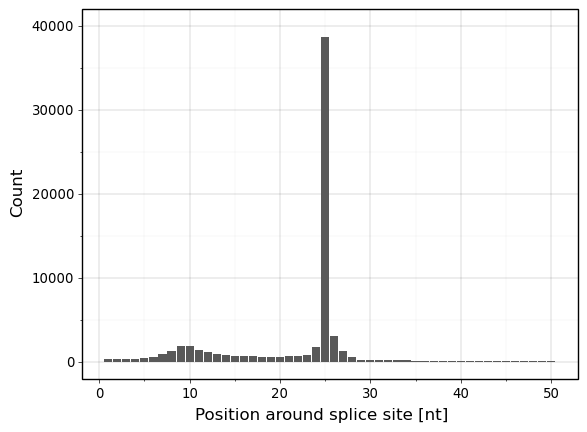

<ggplot: (8784364802197)>

In [20]:
# Plot the results
plt_3end_5ss = (ggplot
     (data = df_3end_5ss, mapping=aes( x = 'new_position', y = 'total_count')) + 
      geom_bar(stat = 'identity') +
      theme_linedraw(base_size = 12) +
      xlab('Position around splice site [nt]') +
      ylim(0,40000) +
      ylab('Count'))

plt_5end_5ss = (ggplot
     (data = df_5end_5ss, mapping=aes( x = 'new_position', y = 'total_count')) + 
      geom_bar(stat = 'identity') +
      theme_linedraw(base_size = 12) +
      xlab('Position around splice site [nt]') +
      ylim(0,40000) +
      ylab('Count'))

plt_3end_3ss = (ggplot
     (data = df_3end_3ss, mapping=aes( x = 'new_position', y = 'total_count')) + 
      geom_bar(stat = 'identity') +
      theme_linedraw(base_size = 12) +
      xlab('Position around splice site [nt]') +
      ylim(0,40000) +
      ylab('Count'))

plt_5end_3ss = (ggplot
     (data = df_5end_3ss, mapping=aes( x = 'new_position', y = 'total_count')) + 
      geom_bar(stat = 'identity') +
      theme_linedraw(base_size = 12) +
      xlab('Position around splice site [nt]') +
      ylim(0,40000) +
      ylab('Count'))

# show one plot
plt_3end_5ss

In [21]:
# Define a function to write the 3'end coordinate of BED12 data
def get_3end_coord_file(file):
    
    def append_id(file):
        filename = os.path.basename(file)
        name, ext = os.path.splitext(filename)
        return "{name}_{id}{ext}".format(name=name, id='3end', ext=ext)
    
    filestring = file.split('/')[-1].split('_')[0:3]
    sample = '_'.join(filestring) # get sample ID from input file name
    
    df = pd.read_csv(file, delimiter = '\t', names =  ['chr', 'start', 'end', 'name', 'score', 'strand', 'readStart', 'readEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts'])
    
    plus = df.loc[df['strand'] == '+']
    minus = df.loc[df['strand'] == '-']
    columns = ['chr', 'start', 'end', 'name', 'score', 'strand']
    
    plus['start'] = plus['end'] - 1
    plus_out = plus[columns]
    
    minus['end'] = minus['start'] + 1
    minus_out = minus[columns]
    
    out = pd.concat([plus_out, minus_out])
    out['sample'] = sample # write sample name in a new column for each file
    
    out.to_csv(append_id(file), sep = '\t', index = False, header = False)

In [ ]:
for file in dataFiles:
    get_3end_coord_file(file)

In [ ]:
# # Use bedtools intersect to get the counts of just splicing intermediates for all samples separately
# bedtools coverage -s -d -a splicing_int_position.bed -b 1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique_3end.bed > 1_untreated_RSII_splicing_int_cov.txt
# bedtools coverage -s -d -a splicing_int_position.bed -b 1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique_3end.bed > 1_untreated_SQ_splicing_int_cov.txt
# bedtools coverage -s -d -a splicing_int_position.bed -b 2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique_3end.bed > 2_untreated_RSII_splicing_int_cov.txt
# bedtools coverage -s -d -a splicing_int_position.bed -b 2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique_3end.bed > 2_untreated_SQ_splicing_int_cov.txt
# bedtools coverage -s -d -a splicing_int_position.bed -b 3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique_3end.bed > 3_DMSO_RSII_splicing_int_cov.txt
# bedtools coverage -s -d -a splicing_int_position.bed -b 3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique_3end.bed > 3_DMSO_SQ_splicing_int_cov.txt
# bedtools coverage -s -d -a splicing_int_position.bed -b 4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique_3end.bed > 4_DMSO_RSII_splicing_int_cov.txt
# bedtools coverage -s -d -a splicing_int_position.bed -b 4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique_3end.bed > 4_DMSO_SQ_splicing_int_cov.txt

In [22]:
# Combine all outputs from bedtools intersect in one df
# add a column that adds sample name
bedtools_cov_files = []
for file in glob.glob('*_splicing_int_cov.txt'):
    df = pd.read_csv(file, sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'position', 'count'])
    filestring = file.split('/')[-1].split('_')[0:3]
    sample = '_'.join(filestring) # get sample ID from input file name
    df['sample'] = sample
    bedtools_cov_files.append(df)
    
cov_file = pd.concat(bedtools_cov_files)

In [191]:
# Combine counts of intermediates with counts of spliced reads
int_and_spliced = pd.merge(cov_file, spliced_counts, left_on = ['name', 'sample'], right_on = ['i_name', 'sample'], how = 'inner') # note inner join keeps only rows where there has been a splicing status determination, since all introns will have an intermediates count from bedtools
int_and_spliced = int_and_spliced.drop(columns = ['position', 'i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'merged_unspliced'])
int_and_spliced.columns = ['chr', 'start', 'end', 'name', 'score', 'strand', 'intermediates', 'sample', 'spliced']

# keep only introns that have at least 5 spliced and unspliced reads
over5_reads = total_counts.drop_duplicates(subset = 'name')
int_and_spliced_over5 = pd.merge(over5_reads[['name']], int_and_spliced, left_on = 'name', right_on = 'name', how = 'left')

# write out file with spliced and intermediate counts per intron per sample for PRO-seq classifications
int_and_spliced_over5 = int_and_spliced_over5.sort_values(by = 'name')
int_and_spliced_over5.to_csv('intermeidates_spliced_counts_per_intron_per_sample.txt', sep = '\t', index = False, header  = True)

# group all replicates by intron and calculate NIC metric for each intron
NIC = int_and_spliced_over5.groupby(['name']).agg({'spliced':'sum', 'intermediates':'sum'})
NIC['NIC'] = NIC['intermediates'] / (NIC['spliced'] + NIC['intermediates'])

# separate inrons with NIC = 0 since this is the largest category, assign it own bin
# separate all other introns into equal quartiles
NIC_greaterthanzero = NIC.loc[NIC['NIC'] >0]
NIC_zero = NIC.loc[NIC['NIC'] == 0]
NIC_zero['bin'] = 0
NIC_greaterthanzero['bin'] = pd.qcut(NIC_greaterthanzero['NIC'], 4, precision = 2, duplicates = 'drop', labels = ['Q1', 'Q2', 'Q3', 'Q4']) # note the smallest non-zero NIC values is 0.001047, this is the start of the second bin
NIC_binned = pd.concat([NIC_zero, NIC_greaterthanzero])

# count number of introns in each bin
NIC_binned['bin'].value_counts()

0     13179
Q2     2558
Q1     2366
Q4     2326
Q3     2090
Name: bin, dtype: int64

In [200]:
# Get min and max values in each bin
print(NIC_binned.loc[NIC_binned['bin'] == 0]['NIC'].min())
print(NIC_binned.loc[NIC_binned['bin'] == 0]['NIC'].max())
print('\n')
print(NIC_binned.loc[NIC_binned['bin'] == 'Q1']['NIC'].min())
print(NIC_binned.loc[NIC_binned['bin'] == 'Q1']['NIC'].max())
print('\n')
print(NIC_binned.loc[NIC_binned['bin'] == 'Q2']['NIC'].min())
print(NIC_binned.loc[NIC_binned['bin'] == 'Q2']['NIC'].max())
print('\n')
print(NIC_binned.loc[NIC_binned['bin'] == 'Q3']['NIC'].min())
print(NIC_binned.loc[NIC_binned['bin'] == 'Q3']['NIC'].max())
print('\n')
print(NIC_binned.loc[NIC_binned['bin'] == 'Q4']['NIC'].min())
print(NIC_binned.loc[NIC_binned['bin'] == 'Q4']['NIC'].max())
print('\n')

0.0
0.0


0.0010471204188481676
0.06060606060606061


0.061224489795918366
0.1


0.10126582278481013
0.16


0.16129032258064516
0.9230769230769231




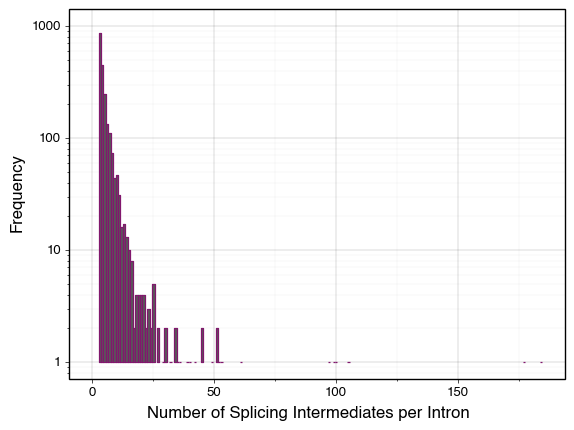

<ggplot: (8784253046885)>

In [170]:
# Plot histogram of number of intermediates per intron
int_hist = (ggplot
     (data = NIC_binned, mapping = aes(x = 'intermediates')) + 
      geom_histogram(binwidth = 1, position = 'stack', alpha = 1, colour = '#81176D') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      scale_y_log10(limits = (1,1000)) +
      xlab('Number of Splicing Intermediates per Intron') +
      ylab('Frequency')
    )

int_hist

In [152]:
# Add information about length, gc, and splice site scores for each intron
NIC_merged = pd.merge(NIC_binned, intron_stats, left_on = 'name', right_on = 'name', how = 'left')

# melt SS score into one column so it can be plotted together
NIC_SSscores = NIC_merged.melt(id_vars = ['name', 'bin'], value_vars = ['fiveSS_score', 'threeSS_score'])

3SS 0 vs Q1:  MannwhitneyuResult(statistic=15529166.0, pvalue=0.3796344552199534)
3SS Q1 vs Q2:  MannwhitneyuResult(statistic=2909844.0, pvalue=0.009826688805609902)
3SS Q2 vs Q3:  MannwhitneyuResult(statistic=2536330.0, pvalue=0.0013259574307800733)
3SS Q3 vs Q4:  MannwhitneyuResult(statistic=2276054.0, pvalue=0.000128527468694012)


5SS 0 vs Q1:  MannwhitneyuResult(statistic=15551059.5, pvalue=0.42171221391033026)
5SS Q1 vs Q2:  MannwhitneyuResult(statistic=3000712.5, pvalue=0.30514020169979794)
5SS Q2 vs Q3:  MannwhitneyuResult(statistic=2644404.5, pvalue=0.2641027101388007)
5SS Q3 vs q4:  MannwhitneyuResult(statistic=2328297.5, pvalue=0.007757335096034295)


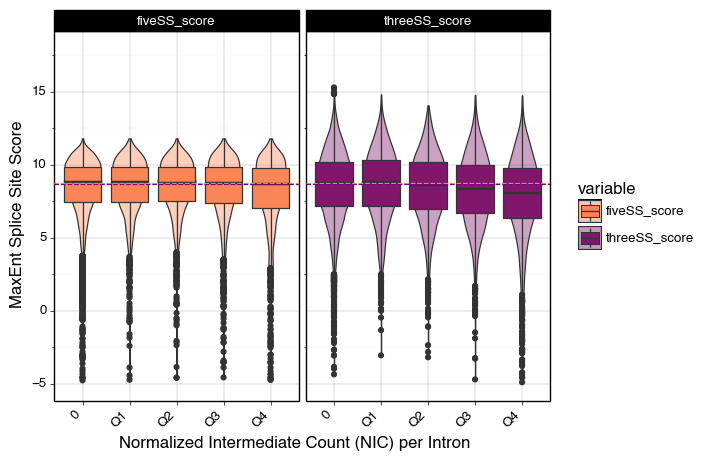

<ggplot: (8784253048821)>

In [155]:
# Plot splice site scores (5'SS and 3'SS) for each category of NIC
my_colours = ['#FA8657', '#81176D']

median_5ss = NIC_SSscores.loc[NIC_SSscores['variable'] == 'fiveSS_score']['value'].median()
median_3ss = NIC_SSscores.loc[NIC_SSscores['variable'] == 'threeSS_score']['value'].median()

plt_NIC_SSscores = (ggplot
     (data=NIC_SSscores, mapping=aes( x='bin', y = 'value', fill = 'variable')) + 
      facet_wrap(facets = 'variable') + 
      geom_violin(width = 0.8, alpha = 0.4) +
      geom_boxplot(width = 0.8, alpha = 1) +
      geom_abline(intercept = median_5ss, slope = 0, colour = 'orange', linetype = 'dashed') +
      geom_abline(intercept = median_3ss, slope = 0, colour = 'purple', linetype = 'dashed') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      theme(panel_grid = None) +
      xlab('Normalized Intermediate Count (NIC) per Intron') +
      ylab('MaxEnt Splice Site Score') +
      ylim(-5,18) +
      scale_fill_manual(values = my_colours)
           )

# calculate p-values between SS scores for each bin with MWU test
p_3ss_0_Q1 = scipy.stats.mannwhitneyu(
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'threeSS_score') & (NIC_SSscores['bin'] == 0)]['value'], 
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'threeSS_score') & (NIC_SSscores['bin'] == 'Q1')]['value'])
p_3ss_Q1_Q2 = scipy.stats.mannwhitneyu(
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'threeSS_score') & (NIC_SSscores['bin'] == 'Q1')]['value'], 
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'threeSS_score') & (NIC_SSscores['bin'] == 'Q2')]['value'])
p_3ss_Q2_Q3 = scipy.stats.mannwhitneyu(
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'threeSS_score') & (NIC_SSscores['bin'] == 'Q2')]['value'], 
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'threeSS_score') & (NIC_SSscores['bin'] == 'Q3')]['value'])
p_3ss_Q3_Q4 = scipy.stats.mannwhitneyu(
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'threeSS_score') & (NIC_SSscores['bin'] == 'Q3')]['value'], 
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'threeSS_score') & (NIC_SSscores['bin'] == 'Q4')]['value'])

p_5ss_0_Q1 = scipy.stats.mannwhitneyu(
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'fiveSS_score') & (NIC_SSscores['bin'] == 0)]['value'], 
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'fiveSS_score') & (NIC_SSscores['bin'] == 'Q1')]['value'])
p_5ss_Q1_Q2 = scipy.stats.mannwhitneyu(
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'fiveSS_score') & (NIC_SSscores['bin'] == 'Q1')]['value'], 
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'fiveSS_score') & (NIC_SSscores['bin'] == 'Q2')]['value'])
p_5ss_Q2_Q3 = scipy.stats.mannwhitneyu(
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'fiveSS_score') & (NIC_SSscores['bin'] == 'Q2')]['value'], 
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'fiveSS_score') & (NIC_SSscores['bin'] == 'Q3')]['value'])
p_5ss_Q3_Q4 = scipy.stats.mannwhitneyu(
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'fiveSS_score') & (NIC_SSscores['bin'] == 'Q3')]['value'], 
    NIC_SSscores.loc[(NIC_SSscores['variable'] == 'fiveSS_score') & (NIC_SSscores['bin'] == 'Q4')]['value'])

print("3SS 0 vs Q1: ", p_3ss_0_Q1)
print("3SS Q1 vs Q2: ", p_3ss_Q1_Q2)
print("3SS Q2 vs Q3: ", p_3ss_Q2_Q3)
print("3SS Q3 vs Q4: ", p_3ss_Q3_Q4)
print('\n')
print("5SS 0 vs Q1: ", p_5ss_0_Q1)
print("5SS Q1 vs Q2: ", p_5ss_Q1_Q2)
print("5SS Q2 vs Q3: ", p_5ss_Q2_Q3)
print("5SS Q3 vs q4: ", p_5ss_Q3_Q4)

plt_NIC_SSscores

0 vs Q1:  MannwhitneyuResult(statistic=15491824.5, pvalue=0.31127773353079247)
Q1 vs Q2:  MannwhitneyuResult(statistic=2786874.5, pvalue=7.924164813948545e-07)
Q2 vs Q3:  MannwhitneyuResult(statistic=2602058.5, pvalue=0.059238578536719384)
Q3 vs Q4:  MannwhitneyuResult(statistic=2198191.5, pvalue=1.9446898227135385e-08)


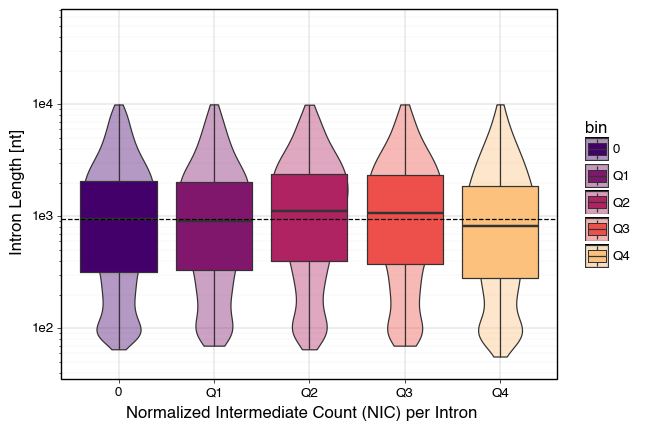

<ggplot: (8784253762853)>

In [168]:
# Plot intron length for each category of NIC
my_colours = ['#43006A', '#81176D', '#B02363', '#ED504A', '#FBC17D']
median_length = NIC_merged['length'].median()

plt_NIC_length = (ggplot
     (data=NIC_merged, mapping=aes( x='bin', y = 'length', fill = 'bin')) + 
      geom_violin(width = 0.8, alpha = 0.4) +
      geom_boxplot(width = 0.8, alpha = 1) +
      geom_abline(intercept = np.log10(median_length), slope = 0, colour = 'black', linetype = 'dashed') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      xlab('Normalized Intermediate Count (NIC) per Intron') +
      ylab('Intron Length [nt]') +
      scale_y_log10(limits = (50, 50000)) +
      scale_fill_manual(values = my_colours))

# Calculate p-values with MW U test
p_len_0_Q1 = scipy.stats.mannwhitneyu(
    NIC_merged.loc[(NIC_merged['bin'] == 0)]['length'],
    NIC_merged.loc[(NIC_merged['bin'] == 'Q1')]['length'])
p_len_Q1_Q2 = scipy.stats.mannwhitneyu(
    NIC_merged.loc[(NIC_merged['bin'] == 'Q1')]['length'],
    NIC_merged.loc[(NIC_merged['bin'] == 'Q2')]['length'])
p_len_Q2_Q3 = scipy.stats.mannwhitneyu(
    NIC_merged.loc[(NIC_merged['bin'] == 'Q2')]['length'],
    NIC_merged.loc[(NIC_merged['bin'] == 'Q3')]['length'])
p_len_Q3_Q4 = scipy.stats.mannwhitneyu(
    NIC_merged.loc[(NIC_merged['bin'] == 'Q3')]['length'],
    NIC_merged.loc[(NIC_merged['bin'] == 'Q4')]['length'])
    
print("0 vs Q1: ", p_len_0_Q1)
print("Q1 vs Q2: ", p_len_Q1_Q2)
print("Q2 vs Q3: ", p_len_Q2_Q3)
print("Q3 vs Q4: ", p_len_Q3_Q4)
plt_NIC_length

0 vs Q1:  MannwhitneyuResult(statistic=14559999.5, pvalue=1.4604237789354416e-07)
Q1 vs Q2:  MannwhitneyuResult(statistic=2963102.0, pvalue=0.10306140749960269)
Q2 vs Q3:  MannwhitneyuResult(statistic=2634594.5, pvalue=0.19869649142064255)
Q3 vs Q4:  MannwhitneyuResult(statistic=2267102.5, pvalue=5.515056595755542e-05)


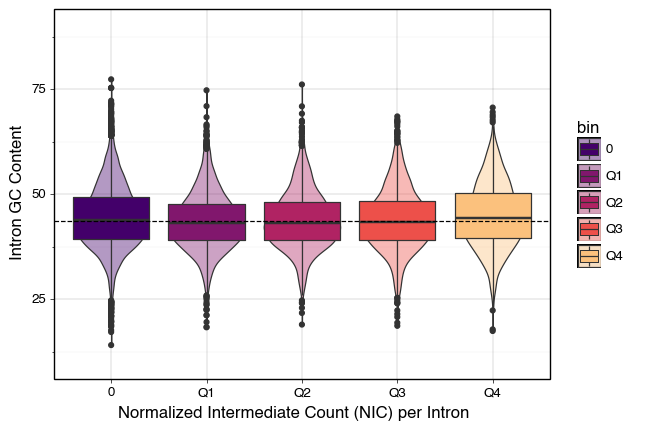

<ggplot: (8784253149885)>

In [169]:
# Plot intron GC content for each category of NIC
my_colours = ['#43006A', '#81176D', '#B02363', '#ED504A', '#FBC17D']
median_gc = NIC_merged['gc'].median()

plt_NIC_gc = (ggplot
     (data=NIC_merged, mapping=aes( x='bin', y = 'gc', fill = 'bin')) + 
      geom_violin(width = 0.8, alpha = 0.4) +
      geom_boxplot(width = 0.8, alpha = 1) +
      geom_abline(intercept = median_gc, slope = 0, colour = 'black', linetype = 'dashed') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      xlab('Normalized Intermediate Count (NIC) per Intron') +
      ylab('Intron GC Content') +
      ylim(10,90) +
      scale_fill_manual(values = my_colours))

# Calculate p-values with MW U test
p_gc_0_Q1 = scipy.stats.mannwhitneyu(
    NIC_merged.loc[(NIC_merged['bin'] == 0)]['gc'],
    NIC_merged.loc[(NIC_merged['bin'] == 'Q1')]['gc'])
p_gc_Q1_Q2 = scipy.stats.mannwhitneyu(
    NIC_merged.loc[(NIC_merged['bin'] == 'Q1')]['gc'],
    NIC_merged.loc[(NIC_merged['bin'] == 'Q2')]['gc'])
p_gc_Q2_Q3 = scipy.stats.mannwhitneyu(
    NIC_merged.loc[(NIC_merged['bin'] == 'Q2')]['gc'],
    NIC_merged.loc[(NIC_merged['bin'] == 'Q3')]['gc'])
p_gc_Q3_Q4 = scipy.stats.mannwhitneyu(
    NIC_merged.loc[(NIC_merged['bin'] == 'Q3')]['gc'],
    NIC_merged.loc[(NIC_merged['bin'] == 'Q4')]['gc'])
    
print("0 vs Q1: ", p_gc_0_Q1)
print("Q1 vs Q2: ", p_gc_Q1_Q2)
print("Q2 vs Q3: ", p_gc_Q2_Q3)
print("Q3 vs Q4: ", p_gc_Q3_Q4)
plt_NIC_gc

In [171]:
# Save outputs
plt_3end_5ss.save('plt_3end_5ss.pdf')
plt_5end_5ss.save('plt_5end_5ss.pdf')
plt_3end_3ss.save('plt_3end_3ss.pdf')
plt_5end_3ss.save('plt_5end_3ss.pdf')

int_hist.save('int_hist.pdf')
plt_NIC_SSscores.save('plt_NIC_SSscores.pdf')
plt_NIC_SSscores_downsampled.save('plt_NIC_SSscores_downsampled.pdf')
plt_NIC_gc.save('plt_NIC_gc.pdf')
plt_NIC_length.save('plt_NIC_length.pdf')

NIC_merged.to_csv('NIC_and_SSscore_per_intron.txt',
                    sep = '\t',
                    header = True,
                    index = False)